Nama : Muhammad Nur Irfan\
ID : MC128D5Y0235\
Path: Fundamental Deep Learning

# **Data Understanding**

## **Data Loading**

Insert Dataset Emosi from Local

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Dataset_emosi.csv to Dataset_emosi.csv


Read csv using pandas

In [ ]:
import pandas as pd
df = pd.read_csv('Dataset_emosi.csv', index_col=[0])

## **Check Data Information**

Check Dataset Content

In [ ]:
df

,teks,label
0,"Anjir lah, kesel banget gue hari ini! Semua se...",Marah
1,"Fix, ini orang bikin naik darah aja kerjaannya.",Marah
2,"Gue udah sabar-sabar, tapi kok malah diinjek-i...",Marah
3,WTF! Gak abis pikir gue sama kelakuan dia.,Marah
4,"Panas banget hati gue, sumpah!",Marah
...,...,...
654,"Bangun tidur denger suara adzan, adem banget r...",Bersyukur
655,"Dapet rekomendasi series bagus pas lagi gabut,...",Bersyukur
656,Bersyukur masih bisa kerja dari rumah di saat ...,Bersyukur
657,Melihat orang lain tersenyum karena kebaikan k...,Bersyukur


Check Dataset Data Types and amount

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559 entries, 0 to 658
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    559 non-null    object
 1   label   559 non-null    object
dtypes: object(2)
memory usage: 13.1+ KB


Check Label Distribution

In [ ]:
print(df['label'].value_counts())

label
Marah        112
Senang       112
Stress       112
Bersyukur    112
Sedih        111
Name: count, dtype: int64


## **Check Data Integrity**

Check Missing Values

In [ ]:
df.isnull().sum()

,0
teks,0
label,0


Check Duplicated Data

In [ ]:
df.duplicated().sum()

np.int64(0)

# **Data Preprocessing**

## **Remove Duplicated Data**

In [ ]:
# Cek data yang hilang dan duplikat
print(df.isna().sum())
print(df.duplicated().sum())

# Hapus duplikat
df = df.drop_duplicates()


teks     0
label    0
dtype: int64
0


## **Remove Special Characters**

In [ ]:
import re

# Contoh: fungsi untuk membersihkan teks
def clean_text(text):
    text = str(text)  # pastikan dalam format string
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # hapus karakter non-alfanumerik kecuali spasi
    text = re.sub(r'\s+', ' ', text).strip()    # hapus spasi berlebih
    return text

# Terapkan ke kolom 'teks'
df['teks'] = df['teks'].apply(clean_text)

# Lihat hasil
print(df['teks'].head())

0    Anjir lah kesel banget gue hari ini Semua serb...
1        Fix ini orang bikin naik darah aja kerjaannya
2    Gue udah sabarsabar tapi kok malah diinjekinje...
3             WTF Gak abis pikir gue sama kelakuan dia
4                         Panas banget hati gue sumpah
Name: teks, dtype: object


## **Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # Simpan le untuk decoding label nanti

## **Tokenization with Transformers**

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize_data(example):
    tokens = tokenizer(
        example["teks"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokens["label"] = example["label"]  # <- sertakan label
    return tokens

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## **Splitting Training and Test Data**

Using Dataset template from Transformers to splitting training and test data so can do training with valid format

In [ ]:
from datasets import Dataset
import numpy as np

dataset = Dataset.from_pandas(df[['teks', 'label']])
dataset = dataset.map(tokenize_data)
dataset = dataset.map(lambda x: {"label": int(x["label"])} if isinstance(x["label"], (np.int64, float)) else x)

# Split data
dataset = dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

# **Modelling**

## **Initiate Pre-train Model**

Using BertForSequenceClassification cause:
1. Our Task is for Emotion Classification
2. We need .h5 model to convert to TFJS

In [ ]:
from transformers import BertForSequenceClassification

num_labels = len(le.classes_)

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", # Select Pre Train model: indobert-base-p1
    num_labels=num_labels
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Set Training Parameters**

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, classification_report

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds)
    }

training_args = TrainingArguments(
    output_dir="./emotion_model_8_10_2-5",        # Folder untuk menyimpan model dan checkpoint
    eval_strategy="epoch",                        # Evaluasi dilakukan setiap akhir epoch
    save_strategy="epoch",                        # Simpan checkpoint model setiap epoch
    learning_rate=2e-5,                           # Learning rate untuk optimizer
    per_device_train_batch_size=8,                # Batch size untuk training per device
    per_device_eval_batch_size=8,                 # Batch size untuk evaluasi per device
    num_train_epochs=10,                          # Jumlah maksimum epoch pelatihan
    weight_decay=0.01,                            # Penurunan bobot (regularisasi) untuk mencegah overfitting
    save_total_limit=2,                           # Maksimum jumlah checkpoint yang disimpan
    load_best_model_at_end=True,                  # Load model terbaik (berdasarkan metrik) di akhir training
    metric_for_best_model="accuracy",             # Metrik yang digunakan untuk menentukan model terbaik
    greater_is_better=True                        # True jika nilai metrik lebih besar berarti lebih baik
)

trainer = Trainer(
    model=model,                                  # Model yang ingin dilatih
    args=training_args,                           # Argumen konfigurasi pelatihan
    train_dataset=dataset['train'],               # Dataset untuk training
    eval_dataset=dataset['test'],                 # Dataset untuk evaluasi
    compute_metrics=compute_metrics,              # Fungsi untuk menghitung metrik
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop training jika metrik tidak membaik setelah 2 epoch
)

## **Training Model**

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chifanuub (chifanuub-nuub) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.471481,0.857143
2,No log,0.394970,0.857143
3,No log,0.327478,0.901786
4,No log,0.485399,0.875000
5,No log,0.503172,0.875000


TrainOutput(global_step=280, training_loss=0.289792605808803, metrics={'train_runtime': 134.0721, 'train_samples_per_second': 33.34, 'train_steps_per_second': 4.177, 'total_flos': 147017262101760.0, 'train_loss': 0.289792605808803, 'epoch': 5.0})

## **Evaluate Training Result**

In [ ]:
# Evaluasi model di dataset test
eval_results = trainer.evaluate()

print("📊 Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

📊 Evaluation Results:
eval_loss: 0.3275
eval_accuracy: 0.9018
eval_runtime: 0.8697
eval_samples_per_second: 128.7790
eval_steps_per_second: 16.0970
epoch: 5.0000


<ipython-input-21-4098431415>:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


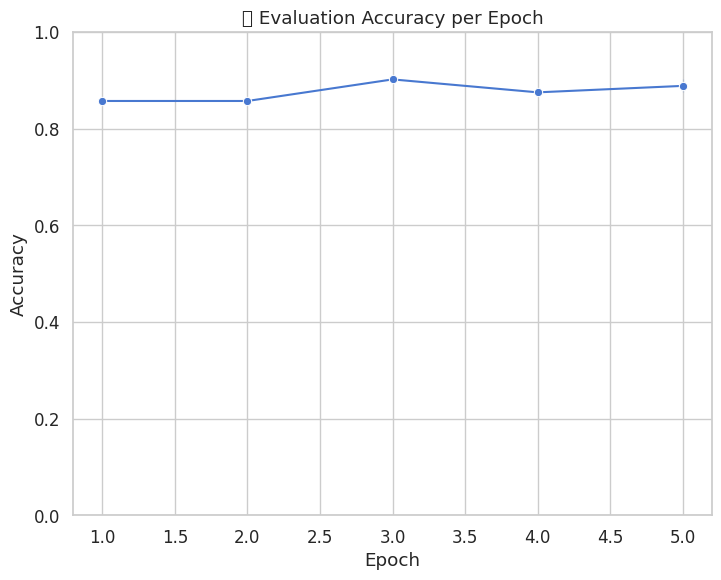

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Pastikan seaborn style diaktifkan
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

log_history = trainer.state.log_history

# Ekstrak log evaluasi
eval_logs = [log for log in log_history if 'eval_accuracy' in log]
epochs = [log['epoch'] for log in eval_logs]
eval_accuracy = [log['eval_accuracy'] for log in eval_logs]

plt.figure(figsize=(14, 6))
# Plot Evaluation Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=eval_accuracy, marker='o')
plt.title('📈 Evaluation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


📋 Classification Report:
              precision    recall  f1-score   support

   Bersyukur       0.96      0.92      0.94        25
       Marah       0.89      0.89      0.89        19
       Sedih       0.79      0.92      0.85        12
      Senang       0.89      0.93      0.91        27
      Stress       0.93      0.86      0.89        29

    accuracy                           0.90       112
   macro avg       0.89      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112



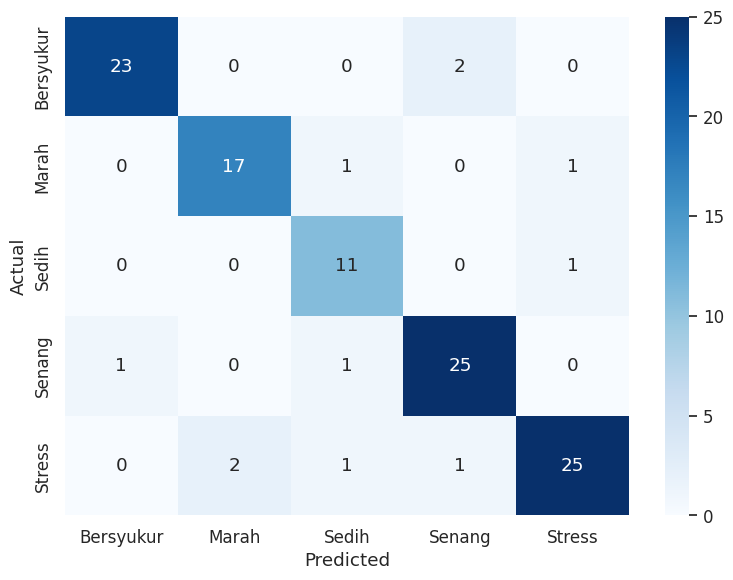

In [ ]:
# Prediksi dan Laporan Klasifikasi
predictions = trainer.predict(dataset['test'])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

print("\n📋 Classification Report:")
print(classification_report(true_labels, preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# **Deployment**

## **Save Model**

In [ ]:
model.save_pretrained("indobert-emotion", saved_model=True) # This code resulting safetensors and h5 model
tokenizer.save_pretrained("indobert-emotion")

('indobert-emotion/tokenizer_config.json',
 'indobert-emotion/special_tokens_map.json',
 'indobert-emotion/vocab.txt',
 'indobert-emotion/added_tokens.json',
 'indobert-emotion/tokenizer.json')

## **Convert model to TFJS**

Install tensorflowjs library

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Using CLI command to convert .h5 model to TFJS

In [ ]:
!tensorflowjs_converter \
--input_format=keras \  #to receive .h5 model format
./indobert-emotion/tf_model.h5 \ #.h5 model location
./tfjs_model\ #tfjs model output dir

2025-05-30 04:11:37.919552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748578297.953481    8104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748578297.963851    8104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


## **Export Model to ZIP**

In [ ]:
import shutil

shutil.make_archive("tfjs_model", "zip", "tfjs_model")

'/content/indobert-emotion.zip'

In [ ]:
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Inferencing Model**

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
# Load tokenizer dan model yang sudah disimpan
model_dir = './indobert-emotion'
tokenizer = BertTokenizer.from_pretrained(model_dir)
model = BertForSequenceClassification.from_pretrained(model_dir)
model.eval()  # set model ke mode evaluation
# Label emosi sesuai dengan training (ubah sesuai label Anda)
label_map = {0: "Bersyukur", 1: "Marah", 2: "Sedih", 3:"Senang", 4:"Stress"}  # Contoh label, sesuaikan dengan dataset Anda
def predict_emotion(text):
    # Tokenisasi input teks
    inputs = tokenizer(text,
                       return_tensors="pt",
                       padding=True,
                       truncation=True,
                       max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)
        predicted_class_id = torch.argmax(probabilities).item()

    emotion = label_map.get(predicted_class_id, "unknown")
    confidence = probabilities[0, predicted_class_id].item()

    return emotion, confidence
# Contoh penggunaan
if __name__ == "__main__":
    input_text = input("Masukkan kalimat untuk prediksi emosi: ")
    emotion, confidence = predict_emotion(input_text)
    print(f"Prediksi emosi: {emotion} (Confidence: {confidence:.2f})")

Masukkan kalimat untuk prediksi emosi: Kok temen aku udah pada dapet magang sedangkan aku belum, aku jadi takut nih
Prediksi emosi: Stress (Confidence: 0.81)


referensi:\
https://huggingface.co/docs/transformers/training  \
https://medium.com/@eza.a.putra/implementasi-bert-untuk-analisis-sentimen-terhadap-ulasan-aplikasi-flip-berbahasa-indonesia-557d691e0440   \
https://www.tensorflow.org/js/tutorials/conversion/import_keras   \
https://www.tensorflow.org/js/tutorials/conversion/import_saved_model